# Finding rare astronomical objects in the ZTF public alert stream

Notebook created by Theophile du Laz (tdulaz@caltech.edu)

Heavily inspired by last year's summer school - excellent - exercises from:
- Robert Stein
- Igor Andreoni

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

### Loading up the data

Here, we'll look at an arbitrary night of ZTF data, and see what we can find. Instead of having all of you query a public ZTF alert broker for a full night of data (that could take some time, and would require some additional code to format things nicely), we have provided a full night of ZTF data in the `data` directory. You should find 3 files:
* ztf_alerts_2460474.5.parquet
* ztf_alerts_2460474.5_prv_candidates.parquet

**ztf_alerts_2460474.5.parquet:**

The first file contains the alerts themselves, in a flattened format we will discuss in a dedicated section. Some fields that would take a lot of space and that are not needed for this analysis have been removed, like the images and some other string-based fields that we do not need.

**ztf_alerts_2460474.5_prv_candidates.parquet:**

This file contains the aggregated previous candidates for each alert. Meaning that for a given objectId, we merged the prv_candidates from all of its alerts (not just those from that night). To keep the amount of data manageable, we:
* only kept up to 6 months of ZTF data, which is more than enough for this purpose.
* we excluded the lightcurves of objects which alerts had low drb scores. We will apply the same score for filtering out bogus alerts anyway, so this should not be a problem.

If you want to recover the lightcurve of a given alert, you can simply look for the rows in this dataset with the same objectId, and then apply a cut on the JD to make sure that you are not "cheating" by looking into the future.

#### Loading the alerts

In [2]:
alerts_path = "./ztfsummerschool_alert_data/ztf_alerts_2460474.5.parquet"

In [3]:
if not os.path.isfile(alerts_path):
    print(f"ERROR: No file found at {alerts_path}. Make sure to download the data first!")

In [4]:
df_alerts = pd.read_parquet(alerts_path)
print(f"Loaded {len(df_alerts)} alerts")

Loaded 153489 alerts


The alerts come as a dataframe, where each row is a flattened ZTF alert packet without:
* cutouts
* prv_candidates
* fp_hists
* some of the string fields that we don't need for this analysis

by flattened, I mean that the real alert packets have this structure:
```
{
    "objectId": "ZTF18abvpirw",
    "candid": 1102223222815015016,
    "candidate": {
        "jd": 2458658.7223229,
        "fid": 1,
        "pid": 1102223222815,
        "diffmaglim": 20.5,
        "programid": 1,
        "candid": 1102223222815015016,
        "isdiffpos": "t",
        "tblid": 1,
        "nid": 1102,
        "rcid": 28,
        "field": 762,
        "ra": 0.0,
        "dec": 0.0,
        "magpsf": 18.0,
        ...
    },
}
```
but here since it's a dataframe, it's flattened to look like this:
```
{
    "objectId": "ZTF18abvpirw",
    "candid": 1102223222815015016,
    "candidate.jd": 2458658.7223229,
    "candidate.fid": 1,
    "candidate.pid": 1102223222815,
    "candidate.diffmaglim": 20.5,
    "candidate.programid": 1,
    "candidate.candid": 1102223222815015016,
    "candidate.isdiffpos": "t",
    "candidate.tblid": 1,
    "candidate.nid": 1102,
    "candidate.rcid": 28,
    "candidate.field": 762,
    "candidate.ra": 0.0,
    "candidate.dec": 0.0,
    "candidate.magpsf": 18.0,
    ...
}

In [5]:
print(f"This ZTF data contains {len(df_alerts)} different alerts, which {len(df_alerts['objectId'].unique())} are unique objects.")

This ZTF data contains 153489 different alerts, which 126195 are unique objects.


In [6]:
# objectIds are attributed to detections with a spatial proximity
# detections are new positons create new objectIds, and subsequent detections at
# the same position are associated with the same objectId
# this is how we keep track of the same object over time, to build lightcurves
print(f"5 random objects: {df_alerts['objectId'].sample(5).values}")

# alerts also come with a unique alert identifier, the candid
# the candid is unique for each alert, and is used to identify the alert
# in the ZTF database
print(f"5 random candid: {df_alerts['candidate.candid'].sample(5).values}")

5 random objects: ['ZTF20aawfmyz' 'ZTF18abusqqg' 'ZTF18abcxfit' 'ZTF19abnzeiv'
 'ZTF23abjksog']
5 random candid: [2720423761415015001 2720409144115010014 2720441653915010060
 2720425191315010020 2720251714215015023]


#### Loading the prv_candidates/lightcurves:

*This file is on the larger side, so it might take a couple of seconds to load.*

In [7]:
lightcurve_path = "./ztfsummerschool_alert_data/ztf_alerts_2460474.5_prv_candidates.parquet"

if not os.path.isfile(lightcurve_path):
    print(f"ERROR: No file found at {lightcurve_path}. Make sure to download the data first!")

df_lightcurve = pd.read_parquet(lightcurve_path)

# the objectId was set as an index here, but we can reset it to have it as a column which
# will be easier to work with
df_lightcurve.reset_index(inplace=True)

In [8]:
df_lightcurve.head()

,objectId,jd,fid,pid,diffmaglim,programid,nid,rcid,field,magzpsci,...,rb,sumrat,magapbig,sigmagapbig,ranr,decnr,scorr,ssdistnr,ssmagnr,ssnamenr
0,ZTF17aaaabas,2.460296e+06,1,2541177292015,20.381701,1,2541,20,776,26.285000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
1,ZTF17aaaabas,2.460296e+06,2,2541264372015,20.252300,1,2541,20,776,26.280199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,ZTF17aaaabas,2.460306e+06,2,2551119292015,19.666100,1,2551,20,776,26.296101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3,ZTF17aaaabas,2.460306e+06,1,2551221002015,18.277201,1,2551,20,776,25.734800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
4,ZTF17aaaabas,2.460308e+06,1,2553147952015,19.969999,1,2553,20,776,26.354900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [9]:
# we can look for a specific object's lightcurve using the objectId column from the alerts, that are used as the index in the lightcurve data
df_lightcurve[df_lightcurve['objectId'] == 'ZTF24aarwzgs']

,objectId,jd,fid,pid,diffmaglim,programid,nid,rcid,field,magzpsci,...,rb,sumrat,magapbig,sigmagapbig,ranr,decnr,scorr,ssdistnr,ssmagnr,ssnamenr
9029080,ZTF24aarwzgs,2.460446e+06,2,2691461093715,20.355301,1,2691,37,335,26.243999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029081,ZTF24aarwzgs,2.460448e+06,1,2693438483715,20.583000,1,2693,37,335,26.169201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029082,ZTF24aarwzgs,2.460450e+06,2,2695376563715,19.544201,1,2695,37,335,26.216101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029083,ZTF24aarwzgs,2.460452e+06,2,2697377853715,19.475100,1,2697,37,335,26.115900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029084,ZTF24aarwzgs,2.460452e+06,1,2697439053715,19.317301,1,2697,37,335,26.094101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029085,ZTF24aarwzgs,2.460456e+06,2,2701394313715,18.577900,1,2701,37,335,26.201599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029086,ZTF24aarwzgs,2.460459e+06,2,2704398553715,19.833401,1,2704,37,335,26.254200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029087,ZTF24aarwzgs,2.460459e+06,1,2704481663715,19.200899,1,2704,37,335,26.165501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029088,ZTF24aarwzgs,2.460462e+06,2,2707393213715,20.552900,1,2707,37,335,26.229500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
9029089,ZTF24aarwzgs,2.460462e+06,1,2707419213715,20.374300,1,2707,37,335,26.146999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


let's write a function that given an alert, returns the lightcurve of the associated object. That is, all the previous detections and non-detections (up to a year) of the object, to which we will apply a cut on the JD to make sure we are not cheating by looking into the future, and then concatenate it with the alert itself.

In [10]:
def get_lightcurve(alert):
    prv_candidates = df_lightcurve[df_lightcurve["objectId"] == alert["objectId"]]
    prv_candidates = prv_candidates[prv_candidates["jd"] < alert["candidate.jd"]]
    # before concatenating the alert, we need to format it the same way as the prv_candidates
    # that is, remove the "candidate." prefix from the column names
    alert_copy = alert.copy()
    alert_copy = {
        key.replace("candidate.", ""): value
        for key, value in alert_copy.items()
    }
    # remove the classifications. and coordinates. fields
    alert_copy = {key: value for key, value in alert_copy.items() if not key.startswith("classifications.") and not key.startswith("coordinates.")}
    prv_candidates = pd.concat([prv_candidates, pd.DataFrame([alert_copy])])
    return prv_candidates

In [11]:
# let's test it here:
alert = df_alerts[df_alerts["objectId"] == "ZTF24aarwzgs"].iloc[0]
lc = get_lightcurve(alert)
lc.head()

,objectId,jd,fid,pid,diffmaglim,programid,nid,rcid,field,magzpsci,...,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,drbversion
9029080,ZTF24aarwzgs,2.460446e+06,2,2691461093715,20.355301,1,2691,37,335,26.243999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9029081,ZTF24aarwzgs,2.460448e+06,1,2693438483715,20.583000,1,2693,37,335,26.169201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9029082,ZTF24aarwzgs,2.460450e+06,2,2695376563715,19.544201,1,2695,37,335,26.216101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9029083,ZTF24aarwzgs,2.460452e+06,2,2697377853715,19.475100,1,2697,37,335,26.115900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9029084,ZTF24aarwzgs,2.460452e+06,1,2697439053715,19.317301,1,2697,37,335,26.094101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


great, now let's plot the lightcurve of an alert.

In [12]:
fid2color = {1: "green", 2: "red", 3: "orange"}
fid2filter = {1: "ztfg", 2: "ztfr", 3: "ztfi"}

def plot_lightcurve(lc, nondet=True):
    # add a "xaxis" column to the lightcurve = jd - jd.min()
    lc["xaxis"] = lc["jd"] - lc["jd"].min() if nondet else lc["jd"] - lc[lc["magpsf"] > 0]["jd"].min()
    plt.figure(figsize=(10, 6))
    for fid, color in fid2color.items():
        lc_fid = lc[lc["fid"] == fid]
        if len(lc_fid) == 0:
            continue
        # then we split detections and non-detections (no magpsf)
        mask_det = lc_fid["magpsf"] > 0
        lc_det = lc_fid[mask_det]
        lc_nondet = lc_fid[~mask_det]
        if len(lc_det) > 0:
            plt.errorbar(lc_det["xaxis"], lc_det["magpsf"], yerr=lc_det["sigmapsf"], fmt='o', color=color, label=fid2filter[fid])
        if len(lc_nondet) > 0 and nondet:
            plt.scatter(lc_nondet["xaxis"], lc_nondet["diffmaglim"], color=color, marker='v', alpha=0.5)
    plt.gca().invert_yaxis() # lower magnitude is brighter (reverse the y-axis)
    plt.xlabel("Time (JD)")
    plt.ylabel("Magnitude")
    plt.title(f"Lightcurve for {lc.iloc[0]['objectId']} at JD {lc.iloc[0]['jd']}")

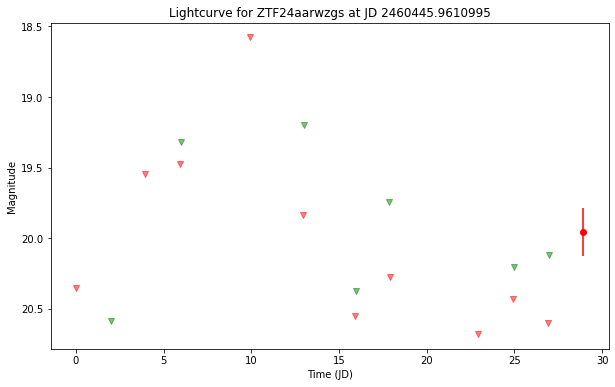

In [13]:
# let's test it here:
lc = get_lightcurve( df_alerts[df_alerts["objectId"] == "ZTF24aarwzgs"].iloc[0])
plot_lightcurve(lc)

This one has only 1 alert which is the only detection, so not much to go on. Let's look at another one.

# Analysing a single source
Let's look more closely at one of these sources:

In [14]:
df_alerts[df_alerts["objectId"] == "ZTF24aambaia"].iloc[0].to_dict()

{'schemavsn': '4.02',
 'publisher': 'ZTF (www.ztf.caltech.edu)',
 'objectId': 'ZTF24aambaia',
 'candidate.jd': 2460474.9316782,
 'candidate.fid': 1,
 'candidate.pid': 2720431672815,
 'candidate.diffmaglim': 20.734350204467773,
 'candidate.pdiffimfilename': 'ztf_20240613431655_000766_zg_c08_o_q1_scimrefdiffimg.fits',
 'candidate.programpi': 'Kulkarni',
 'candidate.programid': 1,
 'candidate.candid': 2720431672815015000,
 'candidate.isdiffpos': 't',
 'candidate.tblid': 0,
 'candidate.nid': 2720,
 'candidate.rcid': 28,
 'candidate.field': 766,
 'candidate.xpos': 251.85260009765625,
 'candidate.ypos': 181.58189392089844,
 'candidate.ra': 289.775013,
 'candidate.dec': 47.5977183,
 'candidate.magpsf': 20.182941436767578,
 'candidate.sigmapsf': 0.17897182703018188,
 'candidate.chipsf': 1.2445534467697144,
 'candidate.magap': 20.590599060058594,
 'candidate.sigmagap': 0.33980000019073486,
 'candidate.distnr': 4.561800479888916,
 'candidate.magnr': 20.558000564575195,
 'candidate.sigmagnr': 0.0

We have a lot of high-level information, for example:
    
- The `drb` (Deep Real/Bogus) score tells us how likely a source is to be real rather than an image artifact. 
- The `ra`/`dec` values tell us where a candidate is on the sky
- The `isdiffpos` field tells us if the source is brighter in this image than in the reference image. For most transient that is true, but for variable stars it can be false, as their magnitude likely varies up and down around an average value, which is what the reference image captures (as it is a stack of many images through long periods of time).
- The `magpsf` field is the magnitude of the source as measured by the point spread function (PSF) photometry. This is the most common way to measure the brightness of a source in astronomical images. The lower the value, the brighter the source.
- The `sigmapsf` field is the uncertainty on the `magpsf` measurement. The lower the value, the more certain we are of the brightness measurement.
- The `distpsnr1` field is the distance to the nearest PS1 source. This is useful to identify if a source is a known object or not.
- The `sgscore1` field is the output of a ML classifier that tells us how likely the closest PS1 source is to be a single star, or a galaxy. This is useful to identify if a source can be resolved as a star or not.
- The "classifications" fields are the output of ML-classifiers we run in the Kowalski broker, and add to every alert to "enrich" them. They are not perfect, but these phenomenological classifiers can be useful to look for hosted transients using acai_h score for example. You can learn more about these classifiers here: https://wandb.ai/dimaduev/acai/reports/Classification-of-astrophysical-events-with-ACAI--VmlldzoxMTkwNjYx
- The coordinates field can be ignored in this analysis for the most part, though `l` & `b` are galactic coordinates, that you could use to look for sources in/outside the galactic plane for example.
...

*There are many more fields in the alert packet, but these are the most relevant for this analysis. You can refer to the full [ZTF alert schema](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html) if needed.*

##### Let's plot this object's lightcurve:

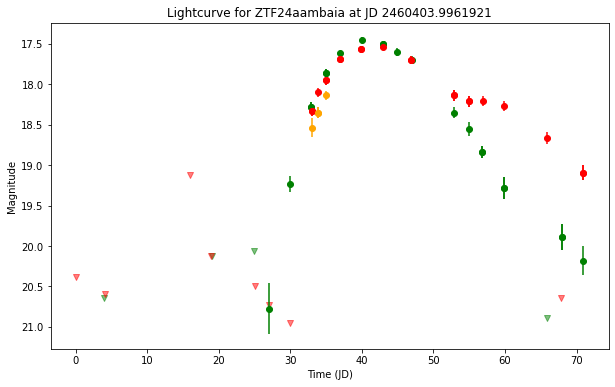

In [15]:
lc = get_lightcurve(df_alerts[df_alerts["objectId"] == "ZTF24aambaia"].iloc[0])
plot_lightcurve(lc)

This one is interesting! It has been detected multiple times in both R and G bands. This is likely a "transient". It does not have a long history of being detected, so is unlikely to be a "variable" object.

We can see that it clearly reaches a peak, and then fades pretty slowly. We also notice that it rises and fades at a different rate in r-band (red) and g-band (green). Many astronomical transients have emission that can be described as a blackbody. Hotter blackbodies appear "blue", cooler ones appear "red". So the lightcurve is telling us that the source starts off somewhat hot (with g-band a little bit brighter than r-band), but then as its magnitude fades, it gets "redder" (red is brighter than blue here, and fades more slowly). Its "color" is getting redder. This is a common feature of supernovae for example, so that could be a good guess for what this object is. We can't be sure without taking additional data (an optical spectrum) though.

This is precisely the kind of objects that programs such as the Bright Transient Survey look for. The goal of the analysis is to come up with ways to find these interesting objects in the 100k+ alerts that ZTF produces every night (in public data stream, the full stream is much larger and harder to deal with). We have enough resources to get spectra for a few objects (maybe dozen per night with SEDM), but certainly not all a hundred thousand. So, we need to identify all the interesting transients in the ZTF data programmatically, review the interesting ones manually, and assign follow-up resources to them.

# Finding the needles in the haystack
How can we narrow down the large number of sources?

In general, our data will contain the following categories of object:
    
- Image artifacts
- Solar system objects
- Stars
- Active Galactic Nuclei
- Transients
    
Your goal is to separate the sources into these five categories. There's no one right answer, but let me give you some tips for how I would do it. You can check the solution notebook for a more complete illustration.

### Image Artifacts
Image artifacts can be best-identified by a well-trained human eye, looking at both raw images and image subtractions. Even an untrained human eye is pretty good at this, you're just looking for something Gaussian-like. However, it would be INSANE for a human to look through 150k different images and identify image artifacts. Instead, ZTF provides a human-eye-approximation, in the form of a neural network (a machine-learning algorithm) thatassigns a score for detections based on whether they look "real" or "bogus". 1=definitely real, 0=definitely bogus. 

**I suggest that you look at a histogram of "drb" scores from the sources. For the purpose of this analysis, we'll simply use 0.5 (as this is also what we used when retrieving the full lightcurves).**

### Solar System Objects
Solar system objects (asteroids, comets, minor planets, satellites) are objects in our solar system. They are charateised by their distinctive feature: unlike distant stars and galaxies, SSOs will move noticeably over the duration of a night. ZTF detections are based on position on the sky. 

**Requiring that an object was detected at least twice in total, in the same position, with a separation of 15 minutes is an excellent way to filter our SSOs.**

*Reminder: you should only count detections (entries in "prv_candidates" with "magpsf"), but NOT count non-detections. Also, don't forget to include the most recent detection ("candidate") and add it to the historical detections ("prv_candidates").*

However, we also have other information in the alert packet that can help us identify SSOs. For example, the `ssdistnr` field tells us the distance to the nearest known solar system object. If this is small, it is likely that the object is a solar system object. So, we can also filter out objects with `ssdistnr` lower than say `10"`, and with a reasonable magnitude range (say `10 < ssmagnr < 20`).


### Stars
Stars can often be identified via the morphology. The PanSTARRS survey is a deeper survey than ZTF, with a catalogue of a billion sources. Machine learning has been used to assign a "Star/Galaxy" score to each of these (1=Star, 0=galaxy, see https://arxiv.org/abs/1902.01935 for more info). ZTF data is cross-matched to these, and the closest three panstarrs sources are included in the alert. The alert includes the magnitudes in g and r (sgmag1/sgmag2/sgmag3), and the star/galaxy score (sgscore1/2/3), for the three nearest sources. The distance to each is provided too (distpsnr1/2/3, in units or arseconds). 

**I would suggest that you make a list of sgscores. Loop over each ZTF source, and add the sgscore of the nearest panstarrs source to your list (that's 'sgscore1'). Make a histogram of these values, and decide where you want to make a cut. Remember, a high sgscore means a source is probably a star! Unlike step 1, where you wanted high drb scores, here we want LOW sgscores.**

**Once you have decided on an sgscore cut, then you should use that to select likely stars. You should loop over each ZTF source, and check the distance to the nearest panstarrs source. If that distance is <3 arcseconds, and the sgscore is less than your threshold, you the source is probably a star.**

### AGN
Active Galactic Nucleii (AGN) are objects that vary in time. Unlike transients, which typically rise and then fall, AGN will often be detected many times over a long period of time. They might not vary very much.

By this point, you should not have many candidates left (e.g I had ~50 sources left). At this point you should start doing human inspection. The easiest way to distinguish AGN/non-AGN is by eye. 

My rule of thumb:

-If there is some indication of a steady rise and/or fall, it is a 'Probable Transient'. 

-If it detected a couple of times within a short timespan of a couple of days, it is a 'Possible Transient'.

-If it is detected in at two different time clusters without evolving much, then you cannot rule out some rise and fall that went in the gap. However, it is unlikely. I would categorise this as 'Probable AGN'. 

-If something is detected many times without a single rapid rise+fall, then it is a 'Definite AGN'. It can either evolve super slowly over thousands of days, or vary both up and down.

As you might realise, my "rule of thumb" is biased, as we are looking for transients and NOT AGNs. We clearly do not have enough information here to classify something as an AGN, but it is enough for us to know that something is not a transient.

Below is an example of each category:

In [17]:
# histogram
df_lightcurve = pd.read_parquet(lightcurve_path)

# the objectId was set as an index here, but we can reset it to have it as a column which
# will be easier to work with
df_lightcurve.reset_index(inplace=True)

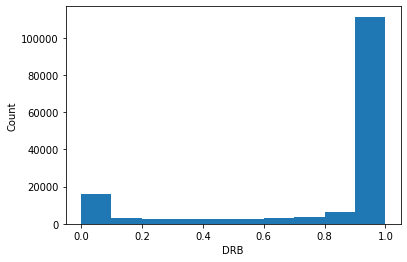

In [68]:
drb = df_alerts['candidate.drb']
plt.xlabel('DRB')
plt.ylabel('Count')
plt.hist(drb);

drb_filter = df_alerts[df_alerts['candidate.drb'] > 0.5]

In [79]:
# filter solar system objects
sso_filter = drb_filter[(df_alerts['candidate.ssdistnr'] < 10) 
                       & (10 < df_alerts['candidate.ssmagnr']) 
                       & (df_alerts['candidate.ssmagnr'] < 20)]

c:\Users\ricco\OneDrive\Desktop\ztf_summer_school_2024\.venv\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


candid
2720441656115015012    0.669247
2720441651015015014    1.000000
2720441650315015017    0.979345
2720444472615015027    0.277560
2720442931215015011    0.640500
                         ...   
2720385332715015001    0.979676
2720385332715015018    0.500000
2720385333715015014    0.500000
2720385333715015006    0.231560
2720385333615015000    0.959667
Name: candidate.sgscore1, Length: 11122, dtype: float64

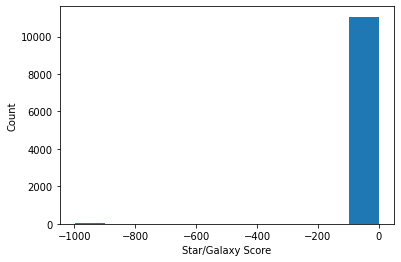

In [84]:
# filter out stars
stars = sso_filter['candidate.sgscore1']
plt.xlabel('Star/Galaxy Score')
plt.ylabel('Count')
plt.hist(stars);

stars

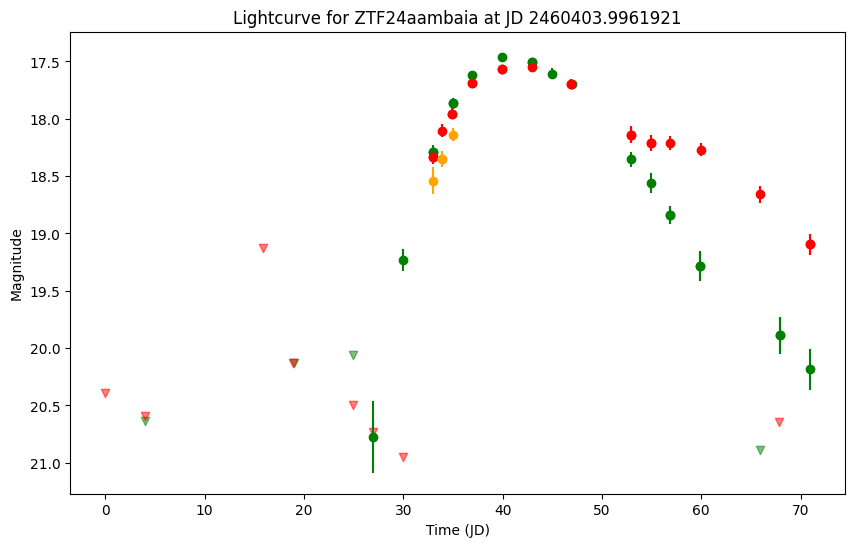

In [ ]:
# Probable transient (our trusty supernova from earlier)
# You can always confirm a SN classification (if it was made public) 
# by looking it up on the Transient Name Server (TNS): https://www.wis-tns.org/
# There you can search by RA and Dec.Here for example, it's https://www.wis-tns.org/object/2024hyh
# and it does have an SN designation, and has been discovered by BTSbot, presented to you earlier this morning,
# and classified as an SN Ia at redshift z=0.045 by the ZTF team as well.
lc = get_lightcurve(df_alerts[df_alerts["objectId"] == "ZTF24aambaia"].iloc[0])
plot_lightcurve(lc)

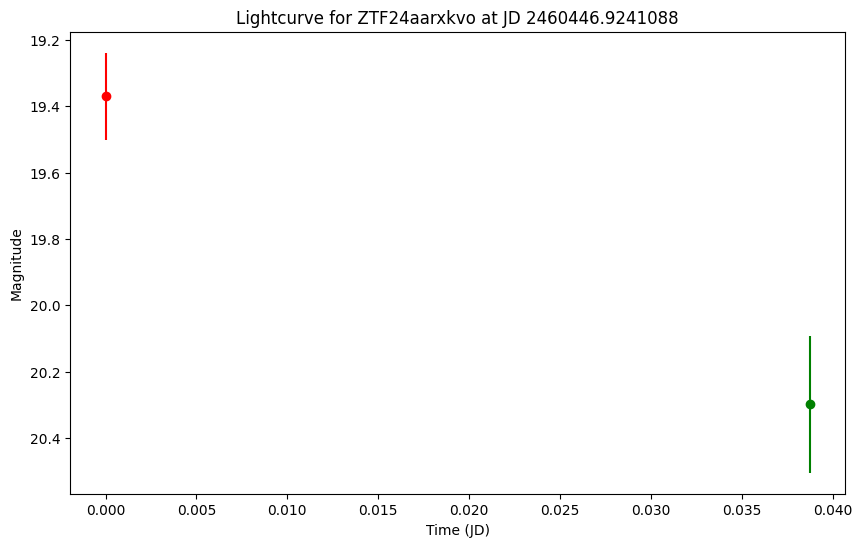

In [ ]:
# Another possible Transient, though we do not have enough data to be sure, and the detections are quite close
lc = get_lightcurve(df_alerts[df_alerts["objectId"] == "ZTF24aarxkvo"].iloc[0])
plot_lightcurve(lc, nondet=False)

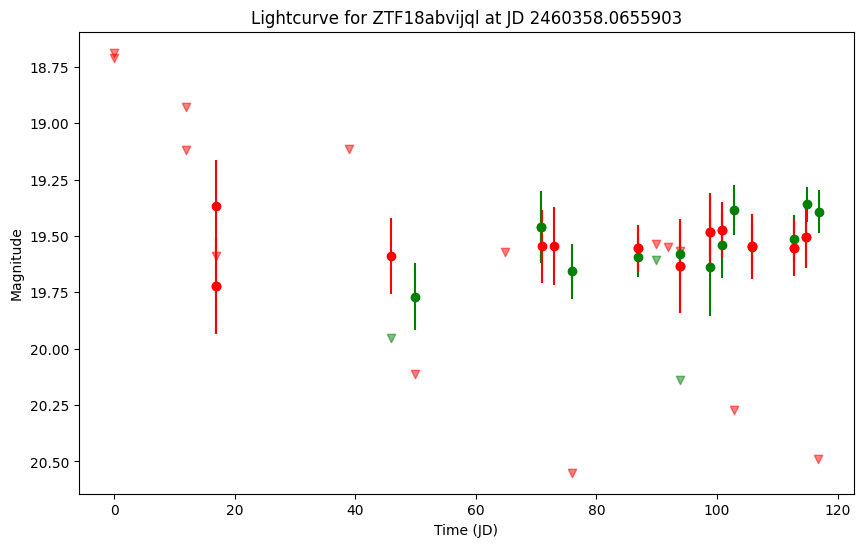

In [ ]:
# Probable AGN
lc = get_lightcurve(df_alerts[df_alerts["objectId"] == "ZTF18abvijql"].iloc[0])
plot_lightcurve(lc)

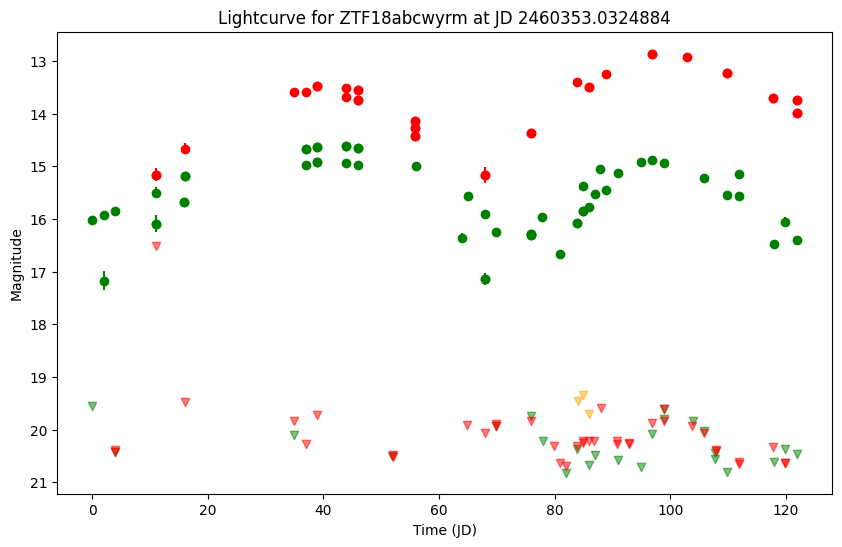

In [ ]:
# possible star that shows some variability, though in a real world scenario we would look at the entire ZTF lightcurve (since 2018)
# to look for periodicity and other patterns
lc = get_lightcurve(df_alerts[df_alerts["objectId"] == "ZTF18abcwyrm"].iloc[0])
plot_lightcurve(lc)

If you want to move beyond "scanning" manually for candidates, you can also look for arcchival detections in https://ned.ipac.caltech.edu/. AGN will often be in catalogues, such as https://heasarc.gsfc.nasa.gov/W3Browse/all/milliquas.html. If somethingf is in Milliquas, it's probaby an AGN. If not, it might still be an AGN.

However, I think the lightcurves can already give you a strong hint. I would suggest you discuss difficult cases with your fellow students. This is what we do in the real world, too! A second (third, or fifth) opinion is always helpful. Also, you can look at a transient on a public broker like Alerce: https://alerce.online/object/ZTF19acudhum. That will help you visualize the entire lightcurve, helpful to distinguish AGN and variable stars from say supernovae.

#### Exercise: look for fast evolving transients

##### Step 1: 
Now, you have a good understanding of how to:
- remove image artifacts using the drb score
- remove solar system objects using the number of detections (with a separation of 15 minutes) and/or the ssdistnr + ssmagnr fields
- remove stars using the distpsnr1/2/3, sgscore1/2/3 fields (hint, just using the sgscore1 + distpsnr1 is enough most of the time)
- optional: rely on the acai scores to look for hosted or nuclear transients (though keep in mind those are ML classifiers and not perfect)
- look for AGN or variable stars (long-lived objects, detected often) using the lightcurve information, or fields such as the `ndethist` (number of detections in the past) and `ncovhist` (number of coverages in the past, includes non-detections), and `jdstarthist` (Julian date of the first ever detection).

This should be enough to remove most things that are not genuine transients, and leave you with a handful of interesting candidates. However you'll still be left with a large amount of objects, and for the sake of this analysis we would like you to focus on the fast evolving transients. 

These are very objects, that rise to a peak and fall in brightness over a short period of time. We would definitely like to follow up on these, especially if they evolve faster than your "typical" supernova.

So, **one more step for you to implement is to try to compute the rate at which said transients are rising or fading, and filter out those that are not evolving quickly enough.**

 - *Hint 1: for a given transient, you can try to identify a peak, and compute rise and fade rates independently.*
 - *Hint 2: You can use some of the fields in the alert packet or the lightcurve itself t compute the `age` of the transient. Useful to filter out older objects and focus on younger ones.*
 - *Hint 3: If you have enough data, you can use the "color" as an information to look for interesting objects, it could be that some objects in this dataset are rising/fading faster in one band than the other, which could be a sign of a peculiar transient.*
*Hint 4: We chose a night where we know there is at least 1 fast evolving transient, try to find it!*

##### Step 2:
We would like you to plot each object. Ideally, you would plot the lightcurve of each object, and maybe some additional information that you think is relevant. Additional information could be features from the alert packet, or custom features that you computed. Also, in a real-world scenario, you would definitely want to see the images of the objects, but we don't provide them here. However, once you filter out the uninsteresting objects, you should be left with a small enough number of objects to inspect them manually. Just like for visualizing the full lightcurve, you can retrieve the images from Alerce: https://alerce.online/object/ZTF19acudhum. You will see that under each image, there is a link formatted in a way that you can retrieve any alert's cutout provided you know the `candid` from the alert packet. Also, if you want to go the extra mile, you can try to retrieve the full lightcurve from Alerce as well, or any other public broker that provides ZTF data (like [Fink](https://fink-portal.org/api), which API service is great for these kind of tasks). To query both Alerce and Fink, you can use the `requests` library in python, and the `json` module to parse the responses if necessary. When downloading the cutouts, Alerce will return them in their original format, which is a `gzip` compressed `fits` file. You can use the `astropy` library to open these files and display the images. You can find an example of how we do this in Kowalski [here](https://github.com/skyportal/kowalski/blob/c8b836e3b93fe81a964feca8105857b81f8f8db0/kowalski/tools/update_ztf_thumbnails_fritz.py#L56-L107). It should be pretty straightforward to adapt this code to your needs. A nice plot could have the 3 images on top of each other on the left, the lightcurve on the right, and some extra metadata on top or at the bottom.


##### Step 3: 
When you done with the filtering and the visualization, we'd like you to rank each object by how interesting you think it is (essentially, prioritize for which object you think we should get a spectrum first). Feel free to implement any ranking system you think is appropriate, manual inspection is also a valid way to rank objects, often the best way to do it. Which is why a strict filter is important, so you don't end up with too many objects to inspect manually.